In [3]:
import os, sys
import pandas as pd 
import numpy as np
from tqdm import tqdm
tqdm.pandas() # for progress_apply

process_dir = os.getcwd() # get the current directory before changing it
if os.getcwd().split("/")[-1] != "lobbying-market":
    sys.path.append("../..") # add main repo directory to path
    os.chdir("../..") # change to main repo directory

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

### Important things to note: 
* We need to lag assets and lobbying costs when calculating the `ratio`. When creating the dataset, may want to do something like a `LEFT JOIN` rather than `INNER JOIN`. (May not apply for LDA Dataset)
* There is some data that has ratio is greater than 1, which is kind of nonsense and highly affects our correlation coefficients (so we should exclude this from our data)
* For a given ratio, it is the Lobbying Expense(Qi) / Asset(Qi-1), since presumably the assets in the previous quarter are used towards the lobbying performed in the present quarter. 
* Here, market performance is the average percent return relative to the stock market if a stock is purchased at the start of a quarter and sold at a random date in the present or future quarter

### Changes from Previous Dataset:
* Please compare approaches between this notebook and the other one. Though the difference is that the other version takes advantage of the structure of the data (nested dataframe structure). 
* The functions that are defined below have been modified slightly to account for changes in the dataset (e.g., treating quarter as an integer rather than a string)

Text(0.5, 1.0, 'Lagged By Quarter')

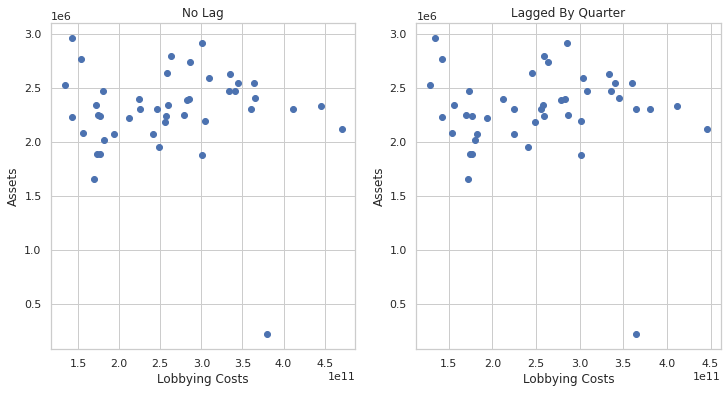

In [4]:
df = pd.read_pickle("LDA_data/all_data_over_threshold.pkl")
df1 = df.loc['MSFT',:,:]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121)
ax.scatter(df1['val'], df1['expenses'])
ax.set_xlabel('Lobbying Costs')
ax.set_ylabel('Assets')
ax.set_title('No Lag')

ax = fig.add_subplot(122)
ax.scatter(df1['val'][:-1], df1['expenses'][1:])
ax.set_xlabel('Lobbying Costs')
ax.set_ylabel('Assets')
ax.set_title('Lagged By Quarter')

Text(0, 0.5, 'Counts')

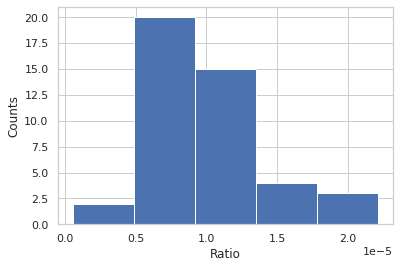

In [5]:
ratio = df1['expenses'].values[1:] / df1['val'].values[:-1] 
plt.hist(ratio, bins=5)
plt.xlabel('Ratio')
plt.ylabel('Counts')

In [6]:
import pandas as pd
from datetime import date
import yfinance as yf
import requests_cache
# Enable caching with requests_cache for an hour
requests_cache.install_cache('yfinance_cache', expire_after=3600)  

# Tickers of companies we want to study
tickers = df.index.get_level_values(0).unique()
tickers = tickers[0]
# Start date and end date of the data we want to download
years = np.array([df1.index[j][0] for j in range(len(df1))])
START = date(years.min(), 1, 1)
END = date(years.max(), 12, 31)
# Downloading the data
data = yf.download(tickers, start=START, end=END)

[*********************100%%**********************]  1 of 1 completed

In [7]:
# Tickers of companies we want to study
tickers = '^GSPC'
# Start date and end date of the data we want to download
START = date(2008, 1, 1)
END = date(2023, 12, 31)
# Downloading the data
sp500_data = yf.download(tickers, start=START, end=END)

[*********************100%%**********************]  1 of 1 completed



### Suppose you know lobbying costs before they are filed. 

In [8]:
def get_start_end(year, quarter):
    if quarter == 1:
        return date(year, 1, 1), date(year, 3, 31)
    elif quarter == 2:
        return date(year, 4, 1), date(year, 6, 30)
    elif quarter == 3:
        return date(year, 7, 1), date(year, 9, 30)
    elif quarter == 4:
        return date(year, 10, 1), date(year, 12, 31)

In [9]:
# return the quarter that is d quarters away from a given quarter
def get_next_quarter(year, quarter, d):
    if quarter == 1:
        if d == 0:
            return year, quarter
        else:
            return get_next_quarter(year, 2, d-1)
    elif quarter == 2:
        if d == 0:
            return year, quarter
        else:
            return get_next_quarter(year, 3, d-1)
    elif quarter == 3:
        if d == 0:
            return year, quarter
        else:
            return get_next_quarter(year, 4, d-1)
    elif quarter == 4:
        if d == 0:
            return year, quarter
        else:
            return get_next_quarter(year+1, 1, d-1)

In [10]:
data.index

DatetimeIndex(['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07',
               '2009-01-08', '2009-01-09', '2009-01-12', '2009-01-13',
               '2009-01-14', '2009-01-15',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=3774, freq=None)

In [11]:
print(data.index.values)

['2009-01-02T00:00:00.000000000' '2009-01-05T00:00:00.000000000'
 '2009-01-06T00:00:00.000000000' ... '2023-12-27T00:00:00.000000000'
 '2023-12-28T00:00:00.000000000' '2023-12-29T00:00:00.000000000']


In [12]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,19.530001,20.400000,19.370001,20.330000,15.038719,50084000
2009-01-05,20.200001,20.670000,20.059999,20.520000,15.179268,61475200
2009-01-06,20.750000,21.000000,20.610001,20.760000,15.356812,58083400
2009-01-07,20.190001,20.290001,19.480000,19.510000,14.432140,72709900
2009-01-08,19.629999,20.190001,19.549999,20.120001,14.883372,70255400
...,...,...,...,...,...,...
2023-12-22,373.679993,375.179993,372.709991,374.579987,373.888580,17091100
2023-12-26,375.000000,376.940002,373.500000,374.660004,373.968445,12673100
2023-12-27,373.690002,375.059998,372.809998,374.070007,373.379547,14905400


In [13]:
date_ex = pd.Timestamp(date(2009,1,2))
print(date_ex)
data.loc[date_ex]

2009-01-02 00:00:00


Open         1.953000e+01
High         2.040000e+01
Low          1.937000e+01
Close        2.033000e+01
Adj Close    1.503872e+01
Volume       5.008400e+07
Name: 2009-01-02 00:00:00, dtype: float64

In [14]:
# use data to obtain the difference in stock price from the first day of a quarter to the first day of a future quarter
def get_stock_price_change(data, year, quarter, d):
    year, quarter = get_next_quarter(year, quarter, 1)
    start, end = get_start_end(year, quarter)
    start = pd.Timestamp(start) ; end = pd.Timestamp(end)
    initial_price = data['Adj Close'].loc[start]
    year, quarter = get_next_quarter(year, quarter, d)
    start, end = get_start_end(year, quarter)
    start = pd.Timestamp(start) ; end = pd.Timestamp(end)
    final_price = data['Adj Close'].loc[start]
    percent_change = 100 * (final_price - initial_price) / initial_price
    return percent_change


In [15]:
# given start and end date, return data indices that are within the range (including start and end)
def get_data_range(data, start, end):
    return data.index[(data.index >= start) & (data.index <= end)]

# get closest date in the future to a given date
def get_next_date(data, date):
    return data.index[data.index >= date][0]

# get closest date in the past to a given date
def get_prev_date(data, date):
    return data.index[data.index <= date][-1]

In [16]:
# use data to obtain the difference in stock price from the first day of a quarter to the first day of a future quarter
def get_avg_stock_price_change(data, year, quarter, d):
    # get the first day of the next quarter
    year, quarter = get_next_quarter(year, quarter, 1)
    start, end = get_start_end(year, quarter)
    start = pd.Timestamp(start) ; end = pd.Timestamp(end)
    if start >= data.index[-1] or end <= data.index[0]:
        return np.nan
    start = get_next_date(data, start) ; end = get_prev_date(data, end)
    initial_price = data['Adj Close'].loc[start]

    # get the first day of the future quarter (d = 0 means you will sell randomly in next quarter)
    year, quarter = get_next_quarter(year, quarter, d)
    start, end = get_start_end(year, quarter)
    dates = get_data_range(data, pd.Timestamp(start), pd.Timestamp(end))
    final_price = data['Adj Close'].loc[dates]
    percent_change = 100 * (final_price - initial_price) / initial_price
    return percent_change.mean()


In [17]:
df1.index.get_level_values

<bound method MultiIndex.get_level_values of MultiIndex([(2009, 2),
            (2009, 3),
            (2009, 4),
            (2010, 1),
            (2010, 2),
            (2010, 3),
            (2010, 4),
            (2011, 1),
            (2011, 2),
            (2011, 3),
            (2011, 4),
            (2012, 1),
            (2012, 2),
            (2012, 3),
            (2012, 4),
            (2013, 1),
            (2013, 2),
            (2013, 3),
            (2013, 4),
            (2014, 1),
            (2014, 2),
            (2014, 3),
            (2014, 4),
            (2015, 1),
            (2015, 2),
            (2015, 3),
            (2015, 4),
            (2016, 1),
            (2016, 2),
            (2016, 3),
            (2016, 4),
            (2017, 1),
            (2017, 2),
            (2017, 3),
            (2017, 4),
            (2018, 1),
            (2018, 2),
            (2018, 3),
            (2018, 4),
            (2019, 1),
            (2019, 2),
            

In [18]:
# use apply to make an array of years and quarters
years = np.array([df1.index[j][0] for j in range(len(df1))])
quarters = np.array([df1.index[j][1] for j in range(len(df1))])

# use apply to get the average stock price change for each row
avg_stock_price_change = pd.Series(np.nan, index=df1.index)
for i in range(len(df1)):
    avg_stock_price_change.iloc[i] = get_avg_stock_price_change(data, years[i], quarters[i], 1)

# add the average stock price change to the dataframe
df1['avg_stock_price_change'] = avg_stock_price_change

/tmp/ipykernel_5849/1785915066.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['avg_stock_price_change'] = avg_stock_price_change


In [19]:
print(quarters)

[2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2
 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4 1 2 3 4]


In [20]:
def get_market_performance(data, sp500_data, year, quarter, d):
    stock_change = get_avg_stock_price_change(data, year, quarter, d)
    sp500_change = get_avg_stock_price_change(sp500_data, year, quarter, d)
    return stock_change - sp500_change

years = np.array([df1.index[j][0] for j in range(len(df1))])
quarters = np.array([df1.index[j][1] for j in range(len(df1))])

# use apply to get the average stock price change for each row
market_performance = pd.Series(np.nan, index=df1.index)
for i in range(len(df1)):
    market_performance.iloc[i] = get_market_performance(data, sp500_data, years[i], quarters[i], 1)

# add the average stock price change to the dataframe
df1['market_performance'] = market_performance

/tmp/ipykernel_5849/1170084688.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['market_performance'] = market_performance


In [21]:
print(df1.market_performance)

year  quarter
2009  2           2.066270
      3           9.286584
      4          -9.137066
2010  1          -7.428089
      2          -2.599449
      3          -1.922943
      4         -13.205133
2011  1          11.377618
      2           9.758224
      3           3.302859
      4           9.193685
2012  1          -3.985572
      2         -11.354656
      3          -9.785962
      4           9.996852
2013  1           9.003179
      2          -2.685394
      3           4.801019
      4           6.418494
2014  1           3.987581
      2          11.318243
      3         -10.254083
      4          -3.535960
2015  1          12.915208
      2          20.781197
      3          17.328169
      4          -7.268925
2016  1          -1.683409
      2          14.818532
      3           5.107813
      4           4.492752
2017  1           7.797597
      2          14.105822
      3          15.404802
      4          13.274097
2018  1          12.874040
      2       

In [22]:
df1['market_performance'].loc[:,:].values.shape

(59,)

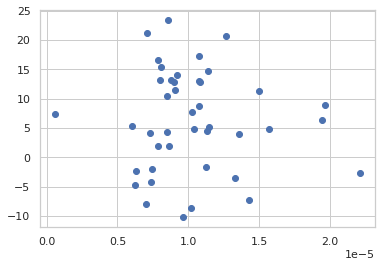

In [23]:
plt.scatter(ratio, df1['market_performance'].loc[:,:].values[1:])

In [24]:
# idx = 73
# ticker = df.index.get_level_values(0).unique()[idx]
# get_market_data(ticker, df.loc[idx,:,:].val)

In [25]:
# let's do this for all the companies in our list now
def get_market_data(ticker, years):
    try:
        # Tickers of companies we want to study
        START = date(years.min(), 1, 1)
        END = date(years.max(), 12, 31)
        # Downloading the data
        data = yf.download(ticker, start=START, end=END)
        return data
    except:
        return ticker
    

tickers = df.index.get_level_values(0).unique()
stock_data_dict = {}
failed_tickers = []
for ticker in tqdm(tickers.values):
    df1 = df.loc[ticker,:,:]
    years = np.array([df1.index[j][0] for j in range(len(df1))])
    market_data = get_market_data(ticker, years)

    stock_data_dict[ticker] = {}
    if type(market_data) == str:
        failed_tickers.append(ticker)
    else:
        stock_data_dict[ticker]['market_data'] = market_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [26]:
def compute_ratio(df1):
    return df1['expenses'].values[1:] / df1['val'].values[:-1]

for ticker in tqdm(tickers.values):
    df1 = df.loc[ticker,:,:]
    if type(market_data) == str:
        failed_tickers.append(ticker)
    else:
        stock_data_dict[ticker]['ratio'] = compute_ratio(df1)

  0%|          | 0/871 [00:00<?, ?it/s]/tmp/ipykernel_5849/3851498471.py:2: RuntimeWarning: invalid value encountered in divide
  return df1['expenses'].values[1:] / df1['val'].values[:-1]
100%|██████████| 871/871 [00:00<00:00, 2389.35it/s]


In [27]:
for ticker in tqdm(tickers.values):
    if ticker in failed_tickers:
        continue

    df1 = df.loc[ticker,:,:]
    years = np.array([df1.index[j][0] for j in range(len(df1))])
    quarters = np.array([df1.index[j][1] for j in range(len(df1))])
    
    data = stock_data_dict[ticker]['market_data']

    # use apply to get the average stock price change for each row
    market_performance = pd.Series(np.nan, index=df1.index)
    for i in range(len(df1)):
        market_performance.iloc[i] = get_market_performance(data, sp500_data, years[i], quarters[i], 1)

    # add the average stock price change to the dataframe
    stock_data_dict[ticker]['market_performance'] = market_performance

100%|██████████| 871/871 [01:21<00:00, 10.69it/s]


In [28]:
stock_data_dict[tickers.values[2]]['market_performance']

year  quarter
2009  1           10.444578
      3           13.691945
      4          -24.315094
2010  1          -33.818652
      2            8.620587
      3           74.202202
      4            9.858012
2011  1          -15.614388
      2           -1.728390
      3            4.320717
      4          -13.066640
2012  1           -9.655845
      2          -11.561828
      3           -8.817661
      4           -0.575972
2013  1           13.487029
      2            1.152482
      3            2.609648
      4           14.855045
2014  1           -3.079205
      2            2.760886
      3           11.078569
      4            6.294547
2015  1            5.226278
      2           49.826267
      3           25.461655
      4           24.948037
2016  1           59.657054
      2           75.726190
      3           48.183258
      4           18.565213
2017  1           49.059346
      2           35.592360
      3           23.318825
      4           21.733361
2018  

100%|██████████| 871/871 [00:02<00:00, 387.77it/s]


Text(0, 0.5, 'Market Performance')

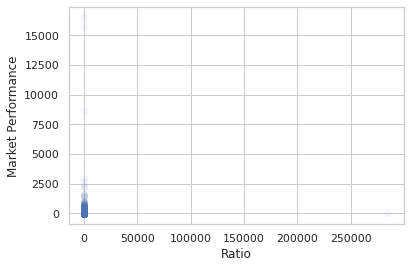

In [29]:
for ticker in tqdm(tickers.values):
    plt.scatter(stock_data_dict[ticker]['ratio'], stock_data_dict[ticker]['market_performance'].loc[:,:].values[1:], c = 'b', alpha = 0.05)
plt.xlabel('Ratio')
plt.ylabel('Market Performance')

100%|██████████| 871/871 [00:02<00:00, 362.23it/s]


(0.0, 1.0)

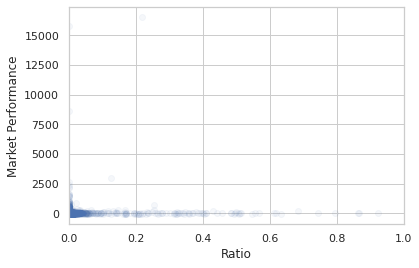

In [30]:
for ticker in tqdm(tickers.values):
    plt.scatter(stock_data_dict[ticker]['ratio'], stock_data_dict[ticker]['market_performance'].loc[:,:].values[1:], c = 'b', alpha = 0.05)
plt.xlabel('Ratio')
plt.ylabel('Market Performance')
plt.xlim([0.,1.])

In [31]:
ratio_all = np.concatenate([stock_data_dict[ticker]['ratio'] for ticker in tickers.values])
market_performance_all = np.concatenate([stock_data_dict[ticker]['market_performance'].loc[:,:].values[1:] for ticker in tickers.values])

In [32]:
# remove nans
arg_nan = np.isnan(ratio_all) | np.isnan(market_performance_all)
ratio_all = ratio_all[~arg_nan]
market_performance_all = market_performance_all[~arg_nan]

In [33]:
np.corrcoef(ratio_all, market_performance_all)

array([[1.00000000e+00, 7.72371557e-05],
       [7.72371557e-05, 1.00000000e+00]])

Text(0, 0.5, 'Market Performance')

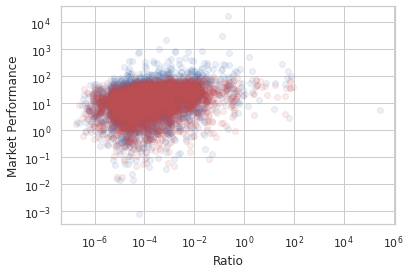

In [34]:
plt.loglog(ratio_all, market_performance_all, 'o', c = 'b', alpha = 0.1)
plt.loglog(ratio_all, -market_performance_all, 'o', c = 'r', alpha = 0.1)
plt.xlabel('Ratio')
plt.ylabel('Market Performance')

In [35]:
# remove outliers (ratio >= 1)
arg_outliers = ratio_all >= 1
ratio_all = ratio_all[~arg_outliers]
market_performance_all = market_performance_all[~arg_outliers]

In [36]:
np.corrcoef(ratio_all, market_performance_all)

array([[1.        , 0.04443009],
       [0.04443009, 1.        ]])

Text(0, 0.5, 'Market Performance')

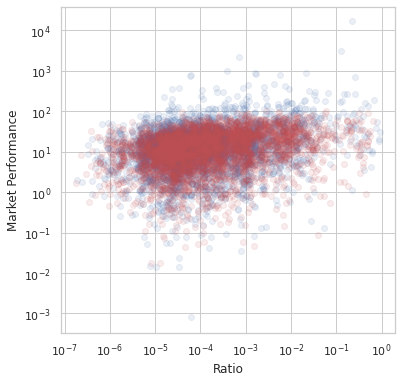

In [37]:
# plot with aspect ratio of 1
plt.figure(figsize=(6,6))
plt.loglog(ratio_all, market_performance_all, 'o', c = 'b', alpha = 0.1)
plt.loglog(ratio_all, -market_performance_all, 'o', c = 'r', alpha = 0.1)
plt.xlabel('Ratio')
plt.ylabel('Market Performance')

100%|██████████| 9/9 [22:42<00:00, 151.38s/it]


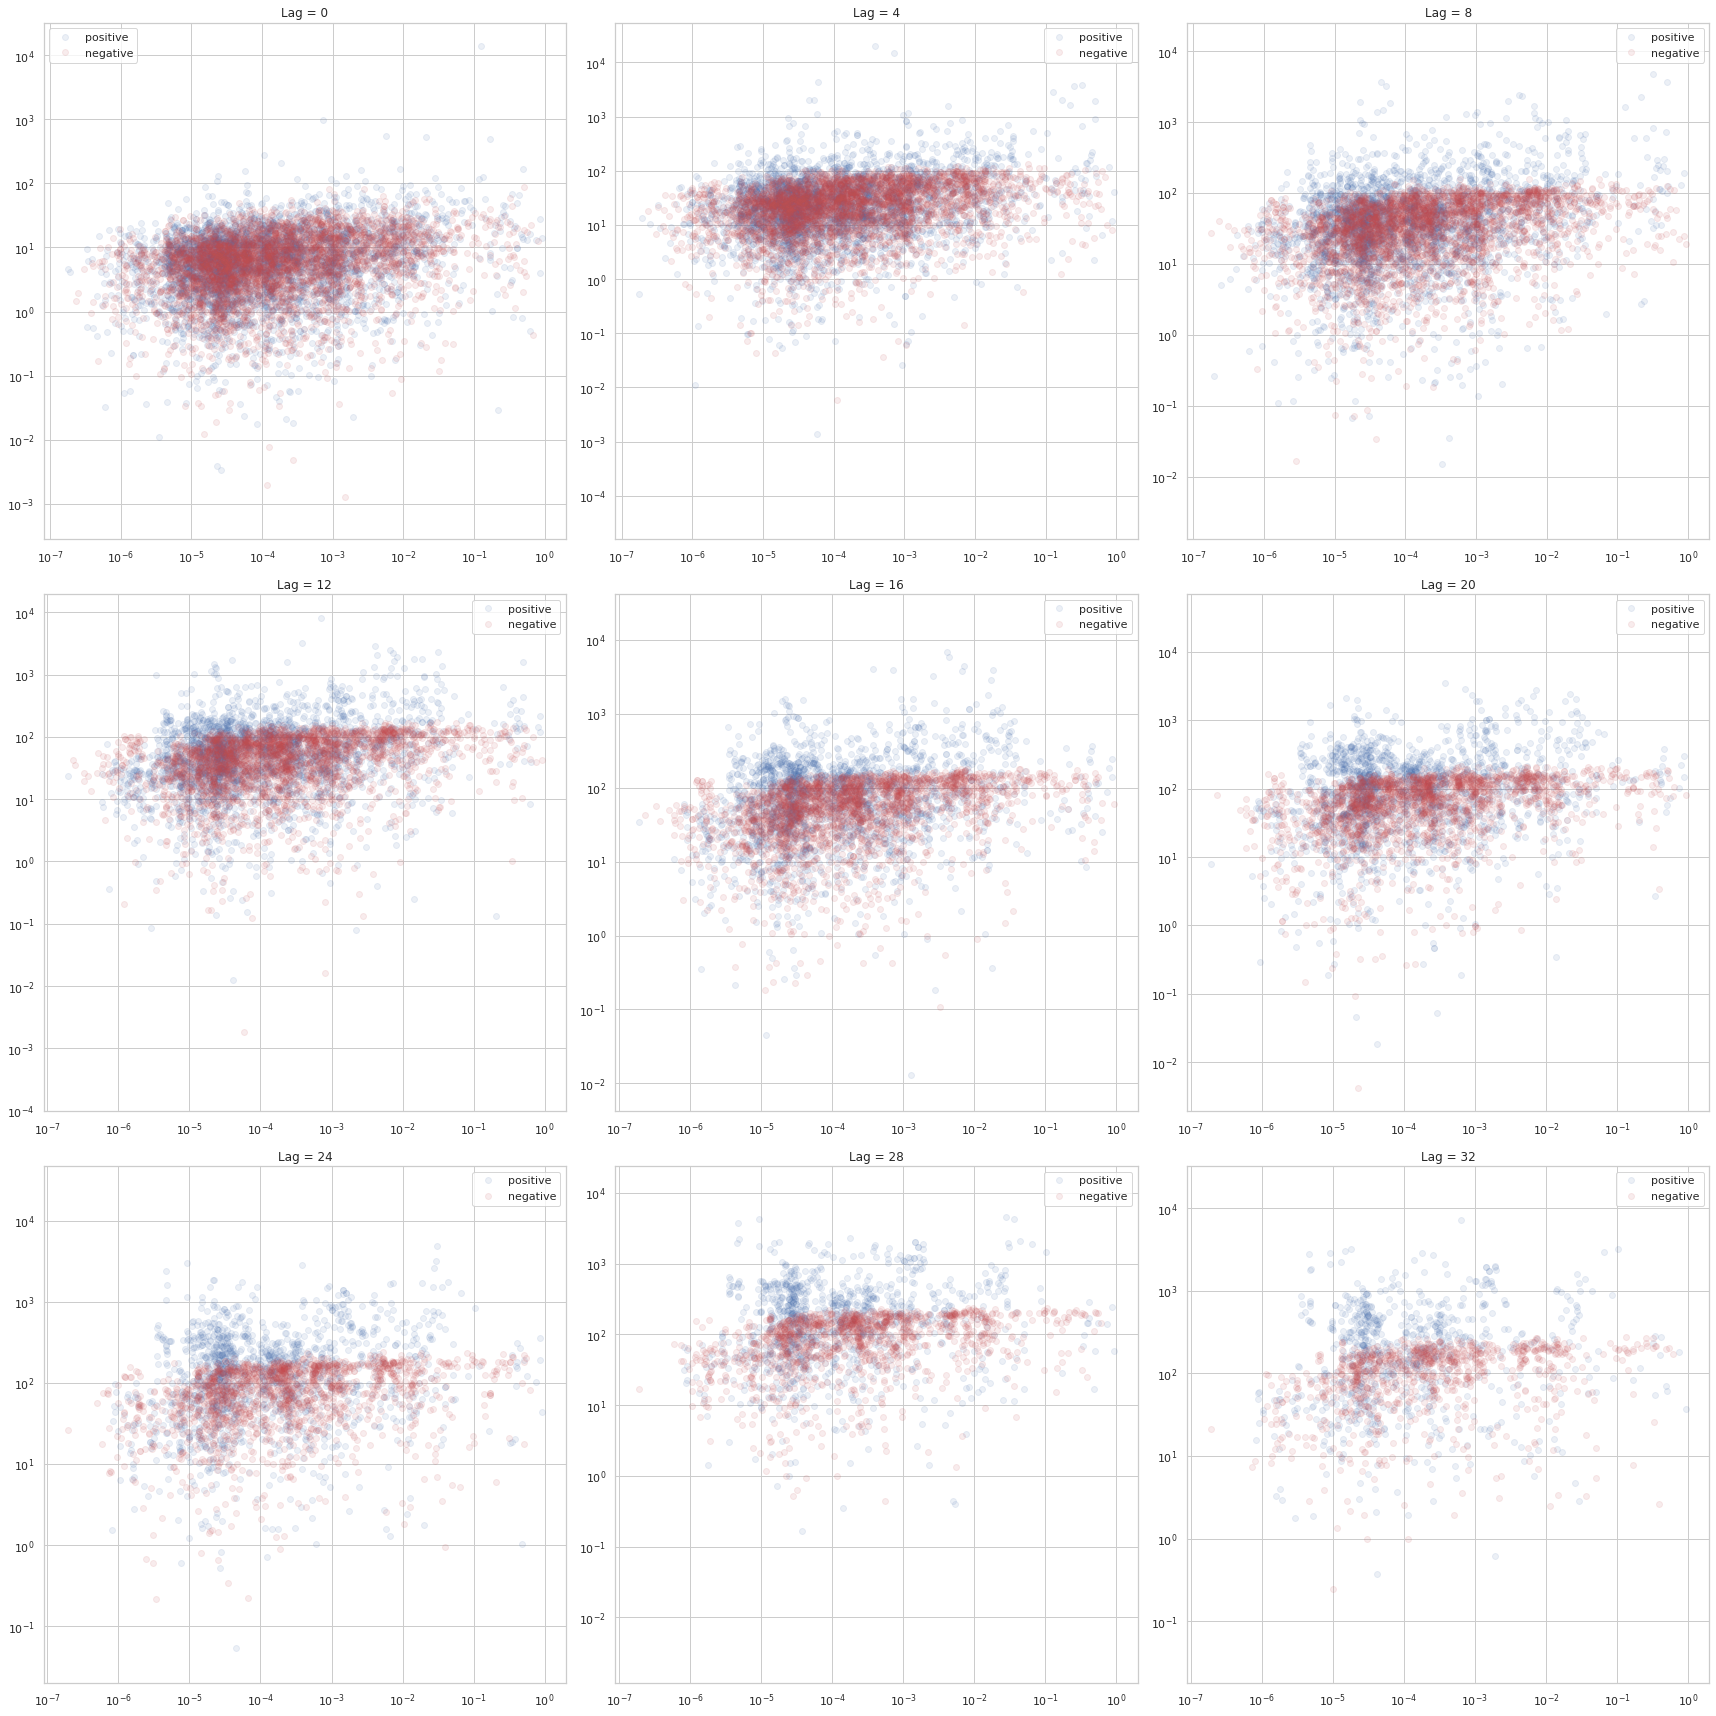

In [39]:
d_list = np.arange(0, 36, 4)
market_performance_list = []
corr_coef_list = []
fig = plt.figure(figsize=(24, 24))
for d in tqdm(d_list):
    for ticker in tickers.values:
        if ticker in failed_tickers:
            continue

        df1 = df.loc[ticker,:,:]
        data = stock_data_dict[ticker]['market_data']

        years = np.array([df1.index[j][0] for j in range(len(df1))])
        quarters = np.array([df1.index[j][1] for j in range(len(df1))])

        # use apply to get the average stock price change for each row
        market_performance = pd.Series(np.nan, index=df1.index)
        for i in range(len(df1)):
            market_performance.iloc[i] = get_market_performance(data, sp500_data, years[i], quarters[i], d)

        # add the average stock price change to the dataframe
        if type(market_data) == str:
            failed_tickers.append(ticker)
        else:
            stock_data_dict[ticker]['market_performance'] = market_performance

        ratio_all = np.concatenate([stock_data_dict[ticker]['ratio'] for ticker in tickers.values])
        market_performance_all = np.concatenate([stock_data_dict[ticker]['market_performance'].loc[:,:].values[1:] for ticker in tickers.values])

    # remove outliers (ratio >= 1)
    arg_outliers = ratio_all >= 1
    ratio_all = ratio_all[~arg_outliers]
    market_performance_all = market_performance_all[~arg_outliers]
    
    # remove nans
    arg_nan = np.isnan(ratio_all) | np.isnan(market_performance_all)
    ratio_all = ratio_all[~arg_nan]
    market_performance_all = market_performance_all[~arg_nan]

    market_performance_list.append(market_performance_all)
    corr_coef = np.corrcoef(ratio_all, market_performance_all)
    corr_coef_list.append(corr_coef[0,1])

    ax = fig.add_subplot(3, 3, d//4 + 1)
    ax.loglog(ratio_all, market_performance_all, 'o', alpha = 0.1, c= 'b', label = 'positive')
    ax.loglog(ratio_all, -market_performance_all, 'o', alpha = 0.1, c = 'r', label = 'negative')
    ax.set_title('Lag = ' + str(d))
    ax.legend()

plt.tight_layout()

Text(0, 0.5, 'Correlation Coefficient')

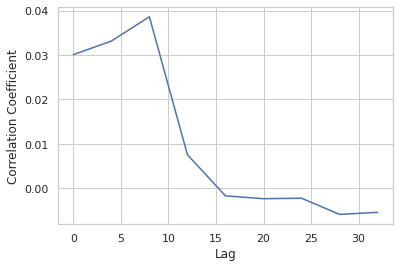

In [41]:
plt.plot(d_list, corr_coef_list)
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')

In [38]:
d_list = np.arange(0,8)
market_performance_list = []
corr_coef_list = []
for d in tqdm(d_list):
    for ticker in tickers.values:
        if ticker in failed_tickers:
            continue
        df1 = df.loc[ticker,:,:]
        data = stock_data_dict[ticker]['market_data']

        years = np.array([df1.index[j][0] for j in range(len(df1))])
        quarters = np.array([df1.index[j][1] for j in range(len(df1))])

        # use apply to get the average stock price change for each row
        market_performance = pd.Series(np.nan, index=df1.index)
        for i in range(len(df1)):
            market_performance.iloc[i] = get_market_performance(data, sp500_data, years[i], quarters[i], d)

        # add the average stock price change to the dataframe
        if type(market_data) == str:
            failed_tickers.append(ticker)
        else:
            stock_data_dict[ticker]['market_performance'] = market_performance

        ratio_all = np.concatenate([stock_data_dict[ticker]['ratio'] for ticker in tickers.values])
        market_performance_all = np.concatenate([stock_data_dict[ticker]['market_performance'].loc[:,:].values[1:] for ticker in tickers.values])

    # remove outliers (ratio >= 1)
    arg_outliers = ratio_all >= 1
    ratio_all = ratio_all[~arg_outliers]
    market_performance_all = market_performance_all[~arg_outliers]
    
    # remove nans
    arg_nan = np.isnan(ratio_all) | np.isnan(market_performance_all)
    ratio_all = ratio_all[~arg_nan]
    market_performance_all = market_performance_all[~arg_nan]

    market_performance_list = []
    corr_coef_list = []

    market_performance_list.append(market_performance_all)
    corr_coef = np.corrcoef(ratio_all, market_performance_all)
    corr_coef_list.append(corr_coef[0,1])

    plt.loglog(ratio_all, market_performance_all, 'o', alpha = 0.1, c= 'b', label = 'positive')
    plt.loglog(ratio_all, -market_performance_all, 'o', alpha = 0.1, c = 'r', label = 'negative')
    plt.xlabel('Ratio')
    plt.ylabel('Market Performance')
    plt.title('Lag = ' + str(d) + ' / ' + 'Correlation = ' + str(np.round(corr_coef[0,1], 8)))
    plt.legend()
    plt.show()


  0%|          | 0/8 [00:34<?, ?it/s]


KeyboardInterrupt: 